**Libraries Import**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import itertools
import random
import os
import csv


In [2]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # # Force TensorFlow to use single thread
    # # Multiple threads are a potential source of non-reproducible results.
    # session_conf = tf.compat.v1.ConfigProto(
    #     intra_op_parallelism_threads=1,
    #     inter_op_parallelism_threads=1
    # )

    # # Make sure that TensorFlow uses a deterministic operation wherever possible
    # tf.compat.v1.set_random_seed(seed)

    # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    # tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

**Data Import**

In [3]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Vehicle dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()
     

In [4]:
# Parse dates and set date column to index
df1 = pd.read_csv("/content/CAR DETAILS FROM CAR DEKHO.csv")
df2 = pd.read_csv("/content/Car details v3.csv")
df3 = pd.read_csv("/content/car data.csv")
df4 = pd.read_csv("/content/car details v4.csv")

In [ ]:
df1.head()

In [ ]:
df2.head()

In [ ]:
df3.head()

In [8]:
df4.head()

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,7.0,55.0


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64


In [19]:
# Remove columns

# How many reviews do we have?
print('There are', df2.shape[0], 'data in this dataset')

# Do we have duplicates?
print('Number of Duplicates:', len(df2[df2.duplicated()]))

# Do we have missing values?
missing_values = df2.isnull().sum()
print('Number of Missing Values by column:\n',missing_values)

print('Number of Missing Values:', df2.isnull().sum().sum())

There are 8128 data in this dataset
Number of Duplicates: 1202
Number of Missing Values by column:
 name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64
Number of Missing Values: 1100


In [ ]:
duplicate_rows = df2[df2.duplicated(keep=False)]
duplicate_rows


In [26]:
# First, get all duplicate rows (keep=False ensures all duplicates are kept)
duplicate_rows = df2[df2.duplicated(keep=False)]

# Then sort the dataframe on all columns to ensure duplicates are adjacent
sorted_duplicates = duplicate_rows.sort_values(by=list(duplicate_rows.columns))

# Now, if we want to see 5 pairs of duplicates (10 rows), we can simply:
top_5_duplicate_pairs = sorted_duplicates.head(10)

top_5_duplicate_pairs


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
1977,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33 bhp,380Nm@ 1750-2500rpm,5.0
7324,Audi Q3 2.0 TDI Quattro Premium Plus,2017,2825000,22000,Diesel,Dealer,Automatic,First Owner,15.73 kmpl,1968 CC,174.33 bhp,380Nm@ 1750-2500rpm,5.0
2129,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4 bhp,580Nm@ 1400-3250rpm,5.0
7775,Audi Q5 3.0 TDI Quattro,2014,1850000,76131,Diesel,Individual,Automatic,First Owner,13.22 kmpl,2967 CC,241.4 bhp,580Nm@ 1400-3250rpm,5.0
131,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
1561,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
1857,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
3236,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
5245,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0
7699,Audi Q5 35TDI Premium Plus,2018,3975000,31800,Diesel,Dealer,Automatic,First Owner,17.01 kmpl,1968 CC,188 bhp,400nm@ 1750-3000rpm,5.0


In [27]:
df2 = df2.drop_duplicates()
print('Number of Duplicates:', len(df2[df2.duplicated()]))


Number of Duplicates: 0


In [28]:
print('Number of Missing Values:', df2.isnull().sum().sum())

Number of Missing Values: 1038


In [29]:
df2 = df2.dropna()


In [30]:
print('Number of Missing Values:', df2.isnull().sum().sum())

Number of Missing Values: 0


In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6717 entries, 0 to 8125
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6717 non-null   object 
 1   year           6717 non-null   int64  
 2   selling_price  6717 non-null   int64  
 3   km_driven      6717 non-null   int64  
 4   fuel           6717 non-null   object 
 5   seller_type    6717 non-null   object 
 6   transmission   6717 non-null   object 
 7   owner          6717 non-null   object 
 8   mileage        6717 non-null   object 
 9   engine         6717 non-null   object 
 10  max_power      6717 non-null   object 
 11  torque         6717 non-null   object 
 12  seats          6717 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 734.7+ KB


**Shuffle the data**

In [33]:
# Shuffle training dataframe
data = df2.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
7039,Chevrolet Cruze LTZ AT,2015,450000,155000,Diesel,Individual,Automatic,First Owner,14.81 kmpl,1998 CC,163.7 bhp,360Nm@ 2000rpm,5.0
5031,Maruti Vitara Brezza ZDi,2017,800000,15381,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0
2807,Tata Indica V2 LSi,2012,75000,12000,Petrol,Individual,Manual,First Owner,16.84 kmpl,1193 CC,64.4 bhp,99.8Nm@ 2700rpm,5.0
1834,Toyota Fortuner 2.8 4WD AT BSIV,2018,3200000,60000,Diesel,Individual,Automatic,First Owner,15.04 kmpl,2755 CC,174.5 bhp,450Nm@ 1600-2400rpm,7.0
4945,Jeep Compass 2.0 Limited Option,2017,1650000,69123,Diesel,Dealer,Manual,First Owner,17.1 kmpl,1956 CC,170 bhp,350Nm@ 1750-2500rpm,5.0


In [36]:
data.describe()

,year,selling_price,km_driven,seats
count,6717.000000,6.717000e+03,6.717000e+03,6717.000000
mean,2013.611136,5.263860e+05,7.339834e+04,5.434271
std,3.897402,5.235504e+05,5.870328e+04,0.983805
min,1994.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.500000e+05,3.800000e+04,5.000000
50%,2014.000000,4.200000e+05,6.820300e+04,5.000000
75%,2017.000000,6.500000e+05,1.000000e+05,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


**Data Cleaning and Pre-processing**

**Feature Engineering**

*Handling Missing Values*

Techniques such as imputation (filling in missing values) or creating a separate 'missing' category can be used.

*Outlier Detection & Treatment*

Outlier Detection: Identifying data points that significantly differ from others. There are various methods for this, such as Z-score, IQR method, DBSCAN, Isolation Forests, etc.

Outlier Treatment: Once identified, outliers can be treated in several ways depending on the nature of the data and the problem. Options include:
Removing the outliers if they are believed to be errors or noise.
Capping the outliers at a certain value.
Transforming the features (e.g., log transformation) to reduce the impact of the outliers.
If the outliers provide valuable information, you may want to keep them and use models that are robust to outliers.

**Encoding Categorical Variables**

Many machine learning algorithms require inputs to be numerical. Techniques like one-hot encoding, label encoding, and target encoding can be used to convert categorical variables into numerical ones.

**Feature Scaling**

Techniques like normalization or standardization to bring all features to a similar scale.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6717 entries, 7039 to 941
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6717 non-null   object 
 1   year           6717 non-null   int64  
 2   selling_price  6717 non-null   int64  
 3   km_driven      6717 non-null   int64  
 4   fuel           6717 non-null   object 
 5   seller_type    6717 non-null   object 
 6   transmission   6717 non-null   object 
 7   owner          6717 non-null   object 
 8   mileage        6717 non-null   object 
 9   engine         6717 non-null   object 
 10  max_power      6717 non-null   object 
 11  torque         6717 non-null   object 
 12  seats          6717 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 734.7+ KB


In [38]:
data = data.drop('name',axis='columns')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6717 entries, 7039 to 941
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           6717 non-null   int64  
 1   selling_price  6717 non-null   int64  
 2   km_driven      6717 non-null   int64  
 3   fuel           6717 non-null   object 
 4   seller_type    6717 non-null   object 
 5   transmission   6717 non-null   object 
 6   owner          6717 non-null   object 
 7   mileage        6717 non-null   object 
 8   engine         6717 non-null   object 
 9   max_power      6717 non-null   object 
 10  torque         6717 non-null   object 
 11  seats          6717 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 682.2+ KB


In [40]:
# Get list of numerical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove 'selling_price' from num_cols
num_cols.remove('selling_price')

# Get list of categorical columns
cat_cols = data.select_dtypes(include=['object']).columns.tolist()

num_cols, cat_cols

(['year', 'km_driven', 'seats'],
 ['fuel',
  'seller_type',
  'transmission',
  'owner',
  'mileage',
  'engine',
  'max_power',
  'torque'])

In [51]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# creating column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer((MinMaxScaler(), num_cols), 
                             (OneHotEncoder(handle_unknown = 'ignore'), cat_cols))

In [52]:
# creating X and y (features and labels)

X = data.drop('selling_price', axis = 1)
y = data['selling_price']

In [53]:
# splitting data into training set and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [44]:
# # fitting column transformer on training data
# ct.fit(X_train)

# # transforming training and test data with normalizing (MinMaxScaler) and one hot encodig (OneHotEncoder)
# X_train = ct.transform(X_train)
# X_test = ct.transform(X_test)

In [54]:
# fitting column transformer on training data
ct.fit(X_train)

# transforming training and test data with normalizing (MinMaxScaler) and one hot encoding (OneHotEncoder)
X_train = ct.transform(X_train).toarray()  # Convert sparse matrix to a dense matrix
X_test = ct.transform(X_test).toarray()    # Convert sparse matrix to a dense matrix


In [55]:
X_train

array([[0.69230769, 0.02076749, 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.61538462, 0.02924402, 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.73076923, 0.02500575, 0.25      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.96153846, 0.00377205, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.00169531, 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.73076923, 0.02331045, 0.16666667, ..., 0.        , 0.        ,
        0.        ]])

**Exploratory Data Analysis (EDA)**

<ipython-input-35-927f007d5064>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt='.2f')


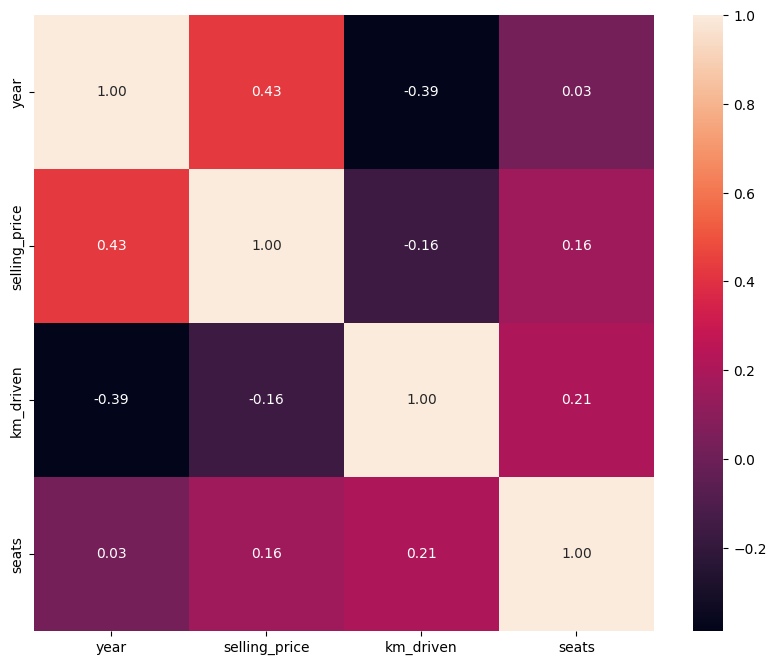

In [35]:
plt.subplots(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, fmt='.2f')
pass

**Cross-Validation**

To ensure the model's generalizability

**Train-Test Split**

plus+ Features and Labels specification

**Model Creation & Model Selection**

Regularization Techniques: To avoid overfitting, like Ridge, Lasso, Elastic Net


**Hyperparameter Tuning**

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
!pip install keras-tuner
import keras_tuner as kt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.1 MB/s eta 0:00:00


In [48]:
LEARNING_RATE=0.001
BATCH_SIZE=32

In [ ]:
X_train

In [60]:
def build_model(hp):
    from keras.layers import BatchNormalization
    from keras.regularizers import l1_l2

    # Define all hyperparameters
    n_layers = hp.Choice('n_layers', [2, 4, 6])
    dropout_rate = hp.Choice('rate', [0.2, 0.4, 0.5, 0.7])
    n_units = hp.Choice('units', [64, 128, 256, 512])
    l1_reg = hp.Choice('l1', [0.0, 0.01, 0.001, 0.0001])
    l2_reg = hp.Choice('l2', [0.0, 0.01, 0.001, 0.0001])

    # Model architecture
    model = Sequential()

    # Input layer
    model.add(Dense(n_units, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(BatchNormalization())
    
    # Add hidden layers 
    for _ in range(n_layers):
        model.add(Dense(n_units, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())

    # Add Dropout Layer
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        loss='mean_squared_error',
        optimizer = Adam(LEARNING_RATE),
        metrics = ['mean_absolute_error']
    )
    
    # Return model
    return model

In [61]:
# Initialize Random Searcher
random_searcher = kt.RandomSearch(
    hypermodel=build_model, 
    objective='val_loss', 
    max_trials=15, 
    seed=42, 
    project_name="Regression_Search"
)

# Start Searching
search = random_searcher.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs = 50,
    batch_size = BATCH_SIZE
)


Trial 15 Complete [00h 01m 20s]
val_loss: 458780770304.0

Best val_loss So Far: 373918498816.0
Total elapsed time: 00h 41m 11s


In [65]:
# Collect the best model Architecture obtained by Random Searcher
best_model = build_model(random_searcher.get_best_hyperparameters(num_trials=1)[0])

# Model Architecture
best_model.summary()

# Compile Model
best_model.compile(
    loss='mean_squared_error',
    optimizer=Adam(LEARNING_RATE),
    metrics=['mean_absolute_error']
)

# Model Training
best_model_history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs = 500,
    batch_size = BATCH_SIZE*2,
    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True),
        ModelCheckpoint("BestModel.h5", save_best_only=True)
    ]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               631808    
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_27 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_28 (Bat  (None, 512)             

In [66]:
#  Load model 
best_model = tf.keras.models.load_model('BestModel.h5')
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               631808    
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_27 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_28 (Bat  (None, 512)             

In [68]:
# Evaluate the best USE model
best_test_loss, best_test_acc = best_model.evaluate(X_test, y_test)
print(f"Validation MSE after Tuning     : {best_test_loss} ")
print(f"Validation MAE after Tuning : {best_test_acc}  ")


42/42 [==============================] - 1s 14ms/step - loss: 42282983424.0000 - mean_absolute_error: 92156.0703
Validation MSE after Tuning     : 42282983424.0 
Validation MAE after Tuning : 92156.0703125  


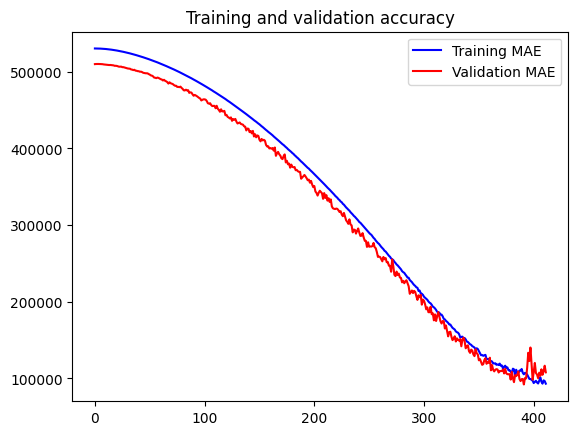

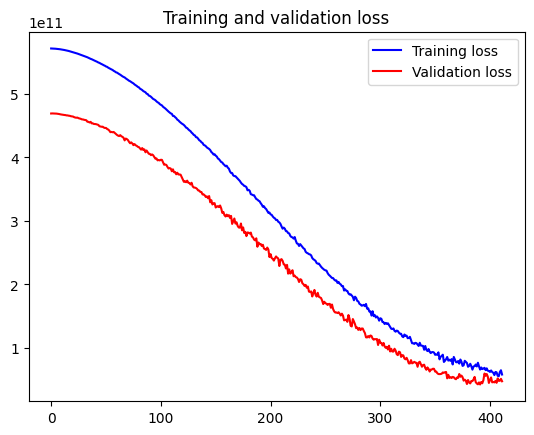

In [69]:
# Extract the history from the best USE model
accuracy = best_model_history.history['mean_absolute_error']
val_accuracy = best_model_history.history['val_mean_absolute_error']

loss = best_model_history.history['loss']
val_loss = best_model_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training MAE')
plt.plot(epochs, val_accuracy, 'r', label='Validation MAE')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()


**Model Ensembling**